<a href="https://colab.research.google.com/github/sujaysavanth/statisticsfordata/blob/main/Hypothesis4_Energy_Model_With_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Hypothesis 4: Can Energy Usage Be Predicted From Population and Fuel Consumption?

In this notebook, we build a **multiple linear regression model** to predict total energy usage using:

- Population
- Gasoline consumption (gallons)
- Diesel consumption (gallons)

We evaluate model performance and interpret coefficients to determine predictive power. Additionally, we visualize actual vs predicted usage, and assess model accuracy using metrics like R², MAE, and MSE.


In [1]:
!pip install pyxlsb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [10]:
file_path = "/content/2016cityandcountyenergyprofiles (1).xlsb"
city_data = pd.read_excel(file_path, engine='pyxlsb', sheet_name='City', skiprows=1)
city_data.columns = city_data.iloc[2]
city_data = city_data.drop([0, 1, 2]).reset_index(drop=True)

# Convert relevant columns
mwh_index = list(city_data.columns).index('consumption (MWh)')
tcf_index = list(city_data.columns).index('consumption (TcF)')

city_df = pd.DataFrame()
city_df['city_name'] = city_data['city_name']
city_df['state_abbr'] = city_data['state_abbr']
city_df['population'] = pd.to_numeric(city_data['population'], errors='coerce')
city_df['electricity_MWh'] = pd.to_numeric(city_data.iloc[:, mwh_index], errors='coerce')
city_df['natural_gas_TcF'] = pd.to_numeric(city_data.iloc[:, tcf_index], errors='coerce')

# Total energy in MWh
city_df['total_energy_MWh'] = city_df['electricity_MWh'] + city_df['natural_gas_TcF'] * 293071

# Get gasoline and diesel gallons
gallon_indexes = city_data.columns.get_indexer_for([col for col in city_data.columns if col == 'consumption (gallons)'])
city_df['gasoline_gallons'] = pd.to_numeric(city_data.iloc[:, gallon_indexes[0]], errors='coerce')
city_df['diesel_gallons'] = pd.to_numeric(city_data.iloc[:, gallon_indexes[1]], errors='coerce')

# Drop rows with missing data
city_df.dropna(subset=['population', 'gasoline_gallons', 'diesel_gallons', 'total_energy_MWh'], inplace=True)


In [11]:
# Define features and target
X = city_df[['population', 'gasoline_gallons', 'diesel_gallons']]
y = city_df['total_energy_MWh']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:,.2f}")
print(f"Mean Squared Error: {mse:,.2f}")



R² Score: 0.7961
Mean Absolute Error: 24,423,419,582.70
Mean Squared Error: 12,288,756,392,552,319,418,368.00


In [12]:
# Coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Interpretation': [
        "Energy increase per additional person",
        "Effect of 1 more gallon of gasoline",
        "Effect of 1 more gallon of diesel"
    ]
})
print(coef_df)

            Feature   Coefficient                         Interpretation
0        population  7.320298e+06  Energy increase per additional person
1  gasoline_gallons -1.210229e+04    Effect of 1 more gallon of gasoline
2    diesel_gallons  1.704951e+04      Effect of 1 more gallon of diesel


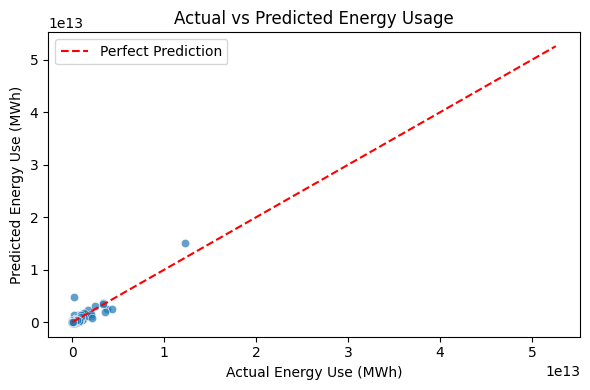

In [13]:
# Visualize actual vs predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', label='Perfect Prediction')
plt.xlabel("Actual Energy Use (MWh)")
plt.ylabel("Predicted Energy Use (MWh)")
plt.title("Actual vs Predicted Energy Usage")
plt.legend()
plt.tight_layout()
plt.show()

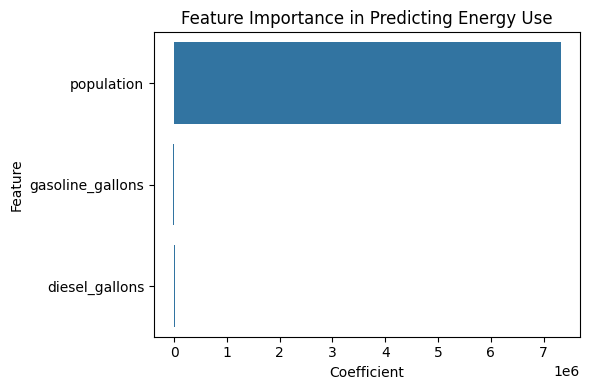

In [14]:
# Feature importance plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("Feature Importance in Predicting Energy Use")
plt.tight_layout()
plt.show()


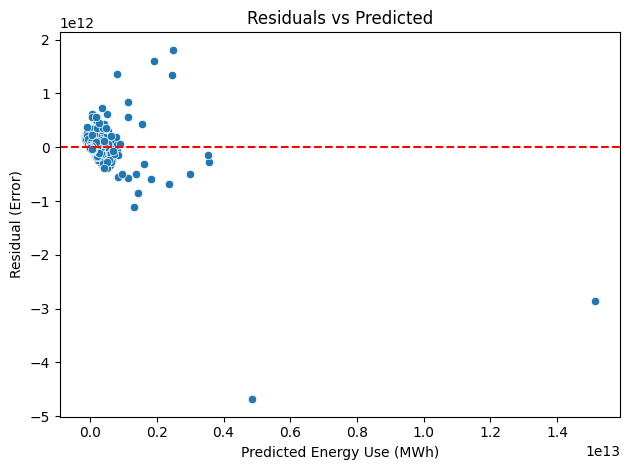

In [15]:
# Residual plot
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Energy Use (MWh)")
plt.ylabel("Residual (Error)")
plt.tight_layout()
plt.show()


In [16]:
# 🔹 Insight 1: City-level prediction table
city_df['predicted_energy_MWh'] = model.predict(X)
city_df['error'] = city_df['total_energy_MWh'] - city_df['predicted_energy_MWh']
city_df['percent_error'] = (city_df['error'] / city_df['total_energy_MWh']) * 100

city_summary = city_df[['city_name', 'state_abbr', 'total_energy_MWh', 'predicted_energy_MWh', 'error', 'percent_error']]
print("\n🔍 Sample City Prediction Table:")
print(city_summary.head())


🔍 Sample City Prediction Table:
         city_name state_abbr  total_energy_MWh  predicted_energy_MWh  \
0   Abbeville city         AL      9.373159e+08          9.702774e+09   
1  Adamsville city         AL      1.308546e+10         -7.468311e+09   
2     Addison town         AL      4.254269e+08          5.500179e+09   
3       Akron town         AL      5.287755e+08          4.628842e+09   
4   Alabaster city         AL      6.099373e+10          1.503632e+11   

          error  percent_error  
0 -8.765458e+09    -935.165794  
1  2.055377e+10     157.073335  
2 -5.074752e+09   -1192.860923  
3 -4.100067e+09    -775.389028  
4 -8.936946e+10    -146.522354  


In [17]:
# 🔹 Insight 2: Outliers
print("\n🔺 Top 5 Overpredicted Cities (Highest % Error):")
print(city_summary.sort_values(by='percent_error', ascending=False).head(5))

print("\n🔻 Top 5 Underpredicted Cities (Lowest % Error):")
print(city_summary.sort_values(by='percent_error', ascending=True).head(5))


🔺 Top 5 Overpredicted Cities (Highest % Error):
                               city_name state_abbr  total_energy_MWh  \
3106   Webster County unified government         GA      16440.694029   
2302                     Glen Ridge town         FL       1258.278186   
12040                        Candia town         NH      12916.363656   
12114                     Hopkinton town         NH      15590.272167   
2356                       Jennings town         FL       3903.050310   

       predicted_energy_MWh         error  percent_error  
3106          -1.432039e+11  1.432039e+11   8.710330e+08  
2302          -2.602222e+09  2.602224e+09   2.068083e+08  
12040         -2.463346e+10  2.463347e+10   1.907152e+08  
12114         -2.557413e+10  2.557415e+10   1.640391e+08  
2356          -3.731629e+09  3.731633e+09   9.560811e+07  

🔻 Top 5 Underpredicted Cities (Lowest % Error):
                     city_name state_abbr  total_energy_MWh  \
13556  Oil Springs Reservation         NY     

<ipython-input-18-c295899a2de4>:5: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


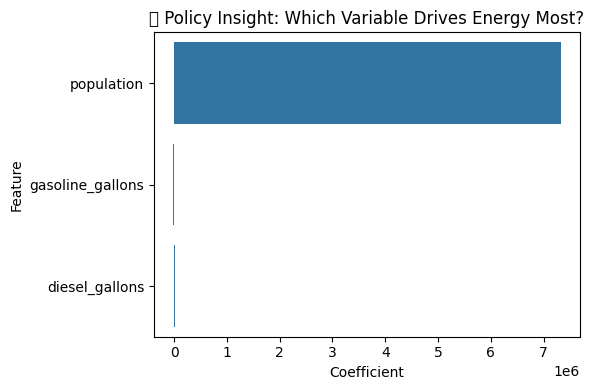

In [18]:
# 🔹 Insight 3: Policy Suggestion
plt.figure(figsize=(6, 4))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("🔍 Policy Insight: Which Variable Drives Energy Most?")
plt.tight_layout()
plt.show()